In [ ]:
import numpy as np
import random
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2

# Define function for inspecting the source code of a function
import inspect
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import Terminal256Formatter

def pretty_print(func):
  source_code = inspect.getsourcelines(func)[0]
  for line in source_code:
    print(highlight(line.strip('\n'), PythonLexer(), Terminal256Formatter()), end='')
  print('')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Load CIFAR-10 data.
cifar10_dir = './datasets/cifar-10'
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


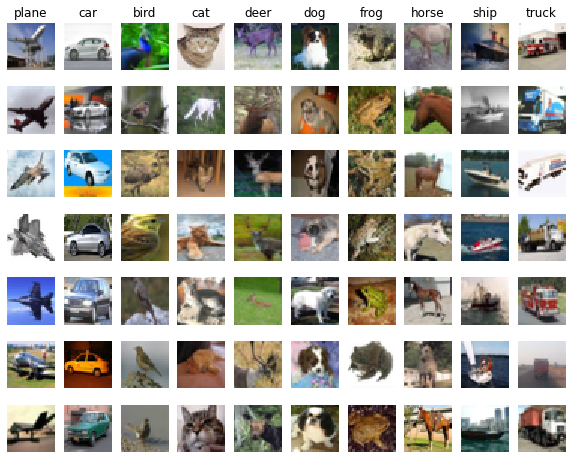

In [ ]:
# Visualization some expl from the dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Sub-sample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [ ]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [ ]:
from cs231n.classifiers import KNearestNeighbor
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)


### Cross-validation
I'm implemented the k-NN classifier.

In [ ]:
k_choices = [1, 3, 5, 8, 10, 12, 15, 20]
num_folds = 5
# Check that training
if num_training/num_folds % num_folds != 0.0:
    raise ValueError('Number of training not evenly divisible.')

# Split training set into num_folds lists
X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

k_to_accuracies = {}
for k in k_choices:
    k_to_accuracies[k] = []
    
for idx in range(num_folds):
    # Use index idx as validation set, rest as training set 
    X_train_set = np.concatenate((*X_train_folds[:idx], *X_train_folds[idx+1:]), axis=0)
    y_train_set = np.concatenate((*y_train_folds[:idx], *y_train_folds[idx+1:]), axis=0)
    X_validation_set = X_train_folds[idx]
    y_validation_set = y_train_folds[idx]   
    num_validation_set = X_validation_set.shape[0]
    # Train kNN classifier
    classifier = KNearestNeighbor()
    classifier.train(X_train_set, y_train_set)
    # Compute distances
    dists_validate = classifier.compute_distances_no_loops(X_validation_set)
for k in k_choices:
    # Predict labels for validation set
    y_validation_pred = classifier.predict_labels(dists_validate, k=k)
    # Check accuracy
    accuracy = (float(np.sum(np.equal(y_validation_pred, y_validation_set)))/num_validation_set)
    k_to_accuracies[k].append(accuracy)

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy for k values = %f' % (k, accuracy))


k = 1, accuracy for k values = 0.266000
k = 3, accuracy for k values = 0.254000
k = 5, accuracy for k values = 0.280000
k = 8, accuracy for k values = 0.273000
k = 10, accuracy for k values = 0.280000
k = 12, accuracy for k values = 0.280000
k = 15, accuracy for k values = 0.274000
k = 20, accuracy for k values = 0.285000


k = 1, average accuracy = 0.266000
k = 3, average accuracy = 0.254000
k = 5, average accuracy = 0.280000
k = 8, average accuracy = 0.273000
k = 10, average accuracy = 0.280000
k = 12, average accuracy = 0.280000
k = 15, average accuracy = 0.274000
k = 20, average accuracy = 0.285000


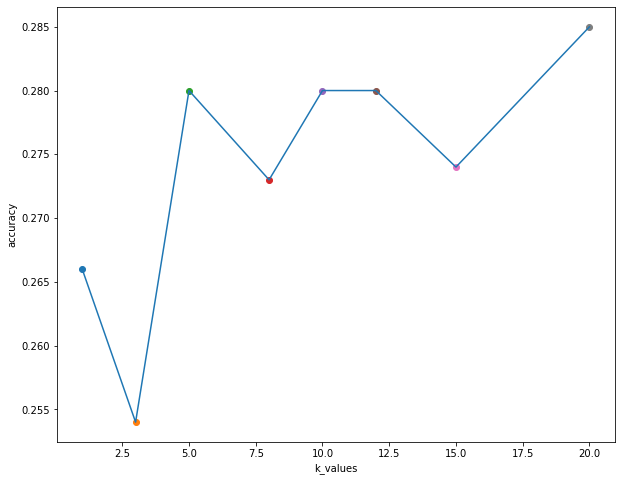

In [ ]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    print('k = %d, average accuracy = %f' % (k, np.average(accuracies)))
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.xlabel('k_values')
plt.ylabel('accuracy')
plt.show()

In [ ]:
best_k = 10
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)
#display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


# Analysis Results
The k-nearest neighbors 'kNN' algorithm is a type of supervised machine learning algorithms. kNN is extremely easy to implement in its most basic form, and yet performs quite complex classification tasks. It is a lazy learning algorithm since it doesn't have a specialized training phase. Rather, it uses all of the data for training while classifying a new data point or instance. KNN is a non-parametric learning algorithm, which means that it doesn't assume anything about the underlying data. This is an extremely useful feature since most of the real-world data doesn't really follow any theoretical assumption of linear-separability and uniform distribution. Although kNN is not a good image classifier, it’s better than a random guess.  An accuracy of 28.2% is obtained by using kNN on CIFAR10 dataset. By using k=10 on the sampled dataset which contains 5000 training and 500 testing samples algorithm could gain 28.2% average accuracy.